
# DS6050 - Group 6
* Andrej Erkelens <wsw3fa@virginia.edu>
* Robert Knuuti <uqq5zz@virginia.edu>
* Khoi Tran <kt2np@virginia.edu>

## Abstract
English is a verbose language with over 69% redundancy in its construction, and as a result, individuals only need to identify important details to comprehend an intended message.
While there are strong efforts to quantify the various elements of language, the average individual can still comprehend a written message that has errors, either in spelling or in grammar.
The emulation of the effortless, yet obscure task of reading, writing, and understanding language is the perfect challenge for the biologically-inspired methods of deep learning.
Most language and text related problems rely upon finding high-quality latent representations to understand the task at hand. Unfortunately, efforts to overcome such problems are limited to the data and computation power available to individuals; data availability often presents the largest problem, with small, specific domain tasks often proving to be limiting.
Currently, these tasks are often aided or overcome by pre-trained large language models (LLMs), designed by large corporations and laboratories.
Fine-tuning language models on domain-specific vocabulary with small data sizes still presents a challenge to the language community, but the growing availability of LLMs to augment such models alleviates the challenge.
This paper explores different techniques to be applied on existing language models (LMs), built highly complex Deep Learning models, and investigates how to fine-tune these models, such that a pre-trained model is used to enrich a more domain-specific model that may be limited in textual data.

## Project Objective

We are aiming on using several small domain specific language tasks, particularly classification tasks.
We aim to take at least two models, probably BERT and distill-GPT2 as they seem readily available on HuggingFace and TensorFlow's model hub.
We will iterate through different variants of layers we fine tune and compare these results with fully trained models, and ideally find benchmarks already in academic papers on all of the datasets.

We aim to optimize compute efficiency and also effectiveness of the model on the given dataset. Our goal is to find a high performing and generalizable method for our fine tuning process and share this in our paper.


In [1]:
%autosave 0

Autosave disabled


In [2]:
!pip install -q tensorflow-addons tensorflow-text tokenizers transformers torch

     |████████████████████████████████| 1.1 MB 8.8 MB/s 
     |████████████████████████████████| 4.6 MB 58.9 MB/s 
     |████████████████████████████████| 6.6 MB 85.0 MB/s 
     |████████████████████████████████| 4.7 MB 65.6 MB/s 
     |████████████████████████████████| 511.7 MB 5.1 kB/s 
     |████████████████████████████████| 438 kB 94.1 MB/s 
     |████████████████████████████████| 1.6 MB 68.6 MB/s 
     |████████████████████████████████| 5.8 MB 55.6 MB/s 
     |████████████████████████████████| 101 kB 12.0 MB/s 
     |████████████████████████████████| 596 kB 92.6 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/ds6050/git/

/content/drive/MyDrive/ds6050/git


In [51]:
from pathlib import Path

import matplotlib.pyplot as plt, numpy as np, os, \
       pandas as pd, re, seaborn as sns, tokenizers, \
       tensorflow as tf, tensorflow_addons as tfa, \
       tensorflow_text as tf_text, torch, transformers

from tensorflow import keras
from tokenizers import decoders, models, normalizers, \
                       pre_tokenizers, processors, trainers

"""from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, \
                            confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB"""
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

"""from gensim.models import Word2Vec"""

np.random.seed(42)
tf.random.set_seed(42)

df = pd.read_feather("data-extractor/data/dataset.feather")#.set_index('index')
df['topic'] = df['topic'].str.split('.').str[0]
df_train = df.sample(frac = 0.6)
df_test = df.drop(df_train.index)

features = 'content' # feature for the future - add all the datasets ['categories', 'summary', 'content']
label = 'topic'

In [35]:
# strategy = tf.distribute.MirroredStrategy()
ohe = OneHotEncoder()

# 7 different topics
# y_ = ohe.fit_transform(df['topic'].values.reshape(-1,1)).toarray()
y_train = ohe.fit_transform(df_train['topic'].values.reshape(-1,1)).toarray()
y_test  = ohe.fit_transform(df_test['topic'].values.reshape(-1,1)).toarray()

max_len = 256
checkpoint = 'gpt2'
hf_gpt2_tokenizer = transformers.GPT2Tokenizer.from_pretrained(checkpoint, add_prefix_space=True)
hf_gpt2_model = transformers.TFGPT2Model.from_pretrained(checkpoint)
# hf_gpt2_model = transformers.GPT2ForSequenceClassification.from_pretrained(checkpoint)

# add for gpt2 padding
if hf_gpt2_tokenizer.pad_token is None:
    hf_gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
hf_gpt2_model.resize_token_embeddings(len(hf_gpt2_tokenizer))

## create model
def model_top(pretr_model):
  input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
  attention_mask = tf.keras.Input(shape=(max_len,), dtype='int32')

  output = pretr_model(input_ids = input_ids, attention_mask = attention_mask)
  pooler_output = tf.keras.layers.AveragePooling1D(pool_size=max_len)(output[0])
  flattened_output = tf.keras.layers.Flatten()(pooler_output)
  
  output = tf.keras.layers.Dense(max_len, activation='relu')(flattened_output)
  output = tf.keras.layers.Dropout(0.4)(output)

  output = tf.keras.layers.Dense(7, activation='softmax')(output)
  model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

train_encodings = hf_gpt2_tokenizer.batch_encode_plus(list(df_train.summary.values), 
                                                      return_tensors='tf', 
                                                      padding='max_length',
                                                      max_length=max_len,
                                                      truncation=True)

test_encodings  = hf_gpt2_tokenizer.batch_encode_plus(list(df_test.summary.values), 
                                                      return_tensors='tf', 
                                                      padding='max_length',
                                                      max_length=max_len,
                                                      truncation=True)

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.
Using pad_token, but it is not set yet.


In [36]:
model = model_top(hf_gpt2_model)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tfgpt2_model_4 (TFGPT2Model)   TFBaseModelOutputWi  124440576   ['input_7[0][0]',                
                                thPastAndCrossAtten               'input_8[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, 256, 76                                         

In [37]:
model.layers

In [38]:
model.layers[2].trainable = False
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tfgpt2_model_4 (TFGPT2Model)   TFBaseModelOutputWi  124440576   ['input_7[0][0]',                
                                thPastAndCrossAtten               'input_8[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, 256, 76                                         

In [39]:
!nvidia-smi

Tue Aug  9 04:42:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    36W / 250W |  15941MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model


q_aware_model = quantize_model(model)
q_aware_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

q_aware_model.summary()

In [ ]:
qhistory = q_aware_model.fit([train_encodings['input_ids'], 
                             train_encodings['attention_mask']], 
                             y_train, 
                             validation_split = 0.2,
                             steps_per_epoch = train_encodings['input_ids'].shape[0] // bat_size,
                             epochs = 2,
                             batch_size = bat_size,
                             callbacks = [model_checkpoint_callback, early_stopping_callback])

In [45]:
checkpoint_filepath = './tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience = 1,
    mode="auto",
)

bat_size = 24
history = model.fit([train_encodings['input_ids'], 
                     train_encodings['attention_mask']], 
                    y_train, 
                    validation_split = 0.2,
                    steps_per_epoch = train_encodings['input_ids'].shape[0] // bat_size,
                    epochs = 8,
                    batch_size = bat_size,
                    callbacks = [model_checkpoint_callback, early_stopping_callback])

Epoch 1/8
1125/1125 [==============================] - 913s 812ms/step - loss: 1.1662 - accuracy: 0.5944 - val_loss: 0.9755 - val_accuracy: 0.6617
Epoch 2/8
1125/1125 [==============================] - 905s 805ms/step - loss: 0.7324 - accuracy: 0.7493 - val_loss: 1.0839 - val_accuracy: 0.6490
Epoch 3/8
1125/1125 [==============================] - 905s 804ms/step - loss: 0.5180 - accuracy: 0.8210 - val_loss: 1.4987 - val_accuracy: 0.6310


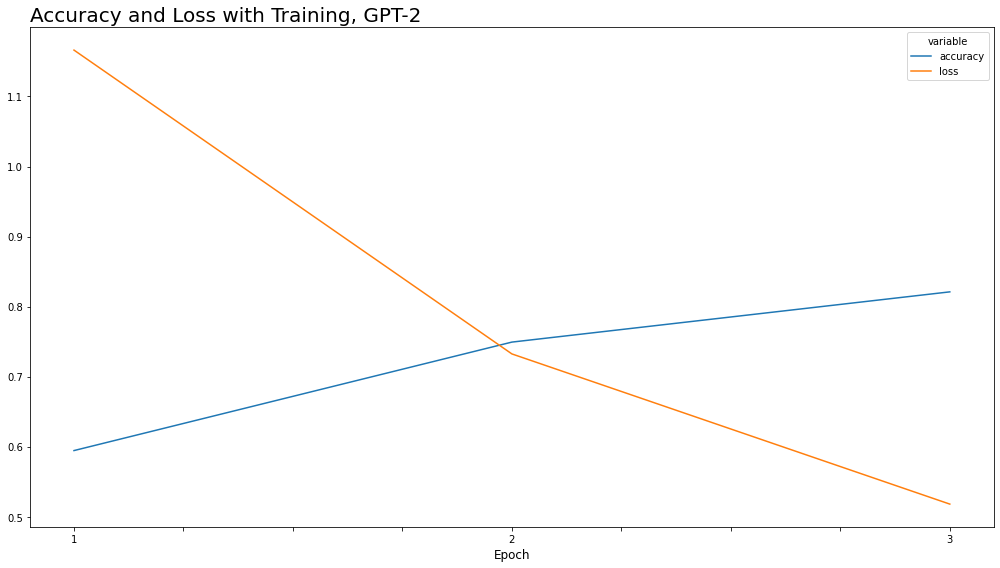

In [47]:
history_df = pd.DataFrame(np.array([history.history['accuracy'], history.history['loss']]).T, columns = ['accuracy', 'loss'])
history_df = history_df.reset_index().rename(columns = {'index': 'epoch'})
history_df['epoch'] = history_df['epoch'] + 1
history_df = pd.melt(history_df, id_vars = 'epoch', value_vars = ['accuracy', 'loss'])

fig, ax = plt.subplots(1, 1, figsize = (14,8))
sns.lineplot(x = 'epoch', y = 'value', hue = 'variable', data = history_df);
# labels, title and ticks
ax.set_xlabel('Epoch', fontsize = 12);
ax.set_ylabel(''); 
ax.set_title('Accuracy and Loss with Training, GPT-2', loc = 'left', fontsize = 20); 
ax.xaxis.set_ticklabels(['','1','','','','2','','','','3']); 
plt.tight_layout()
plt.show()

2252/2252 [==============================] - 202s 90ms/step


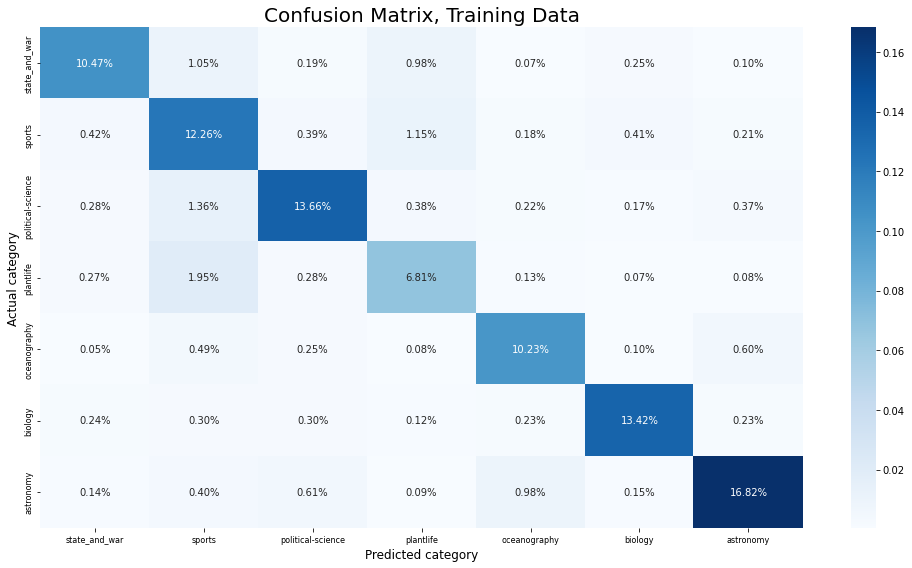

In [52]:
## predict w/ model for evaluation
predict_train_data = model.predict([train_encodings['input_ids'], 
                                    train_encodings['attention_mask']], 
                                   batch_size = 12)
predict_test_data  = model.predict([test_encodings['input_ids'],  
                                    test_encodings['attention_mask']],  
                                   batch_size = 8)

pred_train_data = np.argmax(predict_train_data, axis = 1)
train_cm = confusion_matrix(np.argmax(y_train, axis = 1), pred_train_data)

pred_test_data = np.argmax(predict_test_data, axis = 1)
test_cm = confusion_matrix(np.argmax(y_test, axis = 1), pred_test_data)

## predict with non-fine-tuned model for comparison
model_untr = model_top(hf_gpt2_model)
untr_pred_train = model_untr.predict([train_encodings['input_ids'], 
                                      train_encodings['attention_mask']], 
                                     batch_size=12)
untr_pred_test  = model_untr.predict([test_encodings['input_ids'], 
                                      test_encodings['attention_mask']], 
                                     batch_size=8)

untr_train_cm = confusion_matrix(np.argmax(y_train, axis = 1), 
                                 np.argmax(untr_pred_train, axis = 1))
untr_test_cm = confusion_matrix(np.argmax(y_test, axis = 1), 
                                np.argmax(untr_pred_test, axis = 1))

labels = list(df['topic'].unique())
labels.sort()
x_labs = labels
labels.sort(reverse = True)
y_labs = labels

def plot_cm(cm, title = 'Confusion Matrix'):
  plt.figure(figsize = (14,8))
  ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');
  # labels, title and ticks
  ax.set_xlabel('Predicted category', fontsize = 12);
  ax.set_ylabel('Actual category', fontsize = 12); 
  ax.set_title(title, fontsize = 20); 
  ax.xaxis.set_ticklabels(x_labs, fontsize = 8); 
  ax.yaxis.set_ticklabels(y_labs, fontsize = 8);
  plt.tight_layout()
  plt.show()

In [ ]:
plot_cm(train_cm, 'Confusion Matrix, Training Data')

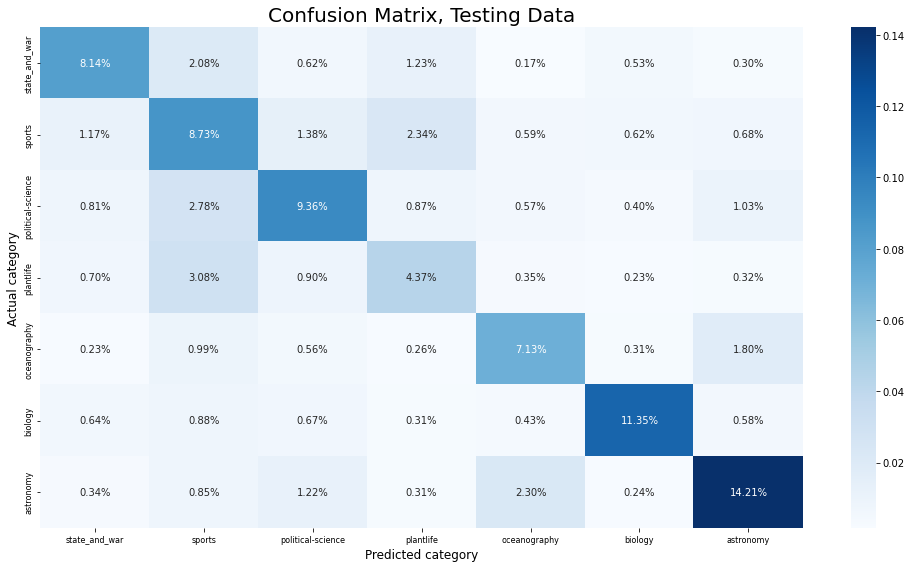

In [54]:
plot_cm(test_cm, 'Confusion Matrix, Testing Data')

2252/2252 [==============================] - 201s 89ms/step


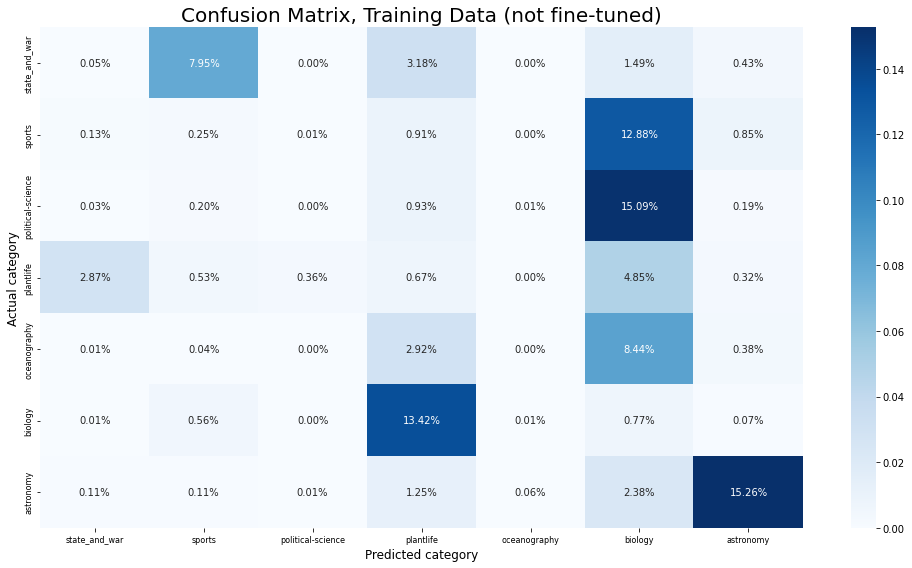

In [55]:
plot_cm(untr_train_cm, 'GPT-2 Confusion Matrix, Training Data (not fine-tuned)')

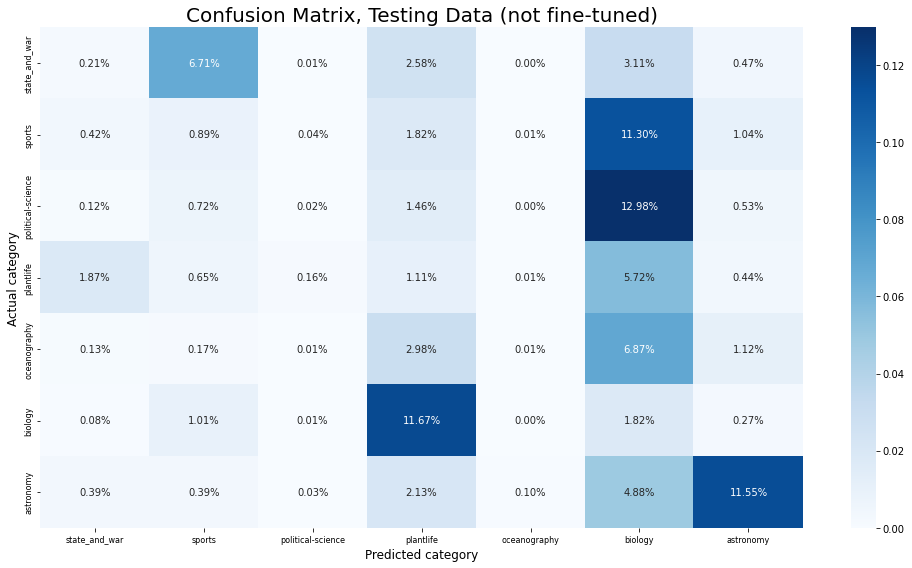

In [56]:
plot_cm(untr_test_cm, 'GPT-2 Confusion Matrix, Testing Data (not fine-tuned)')

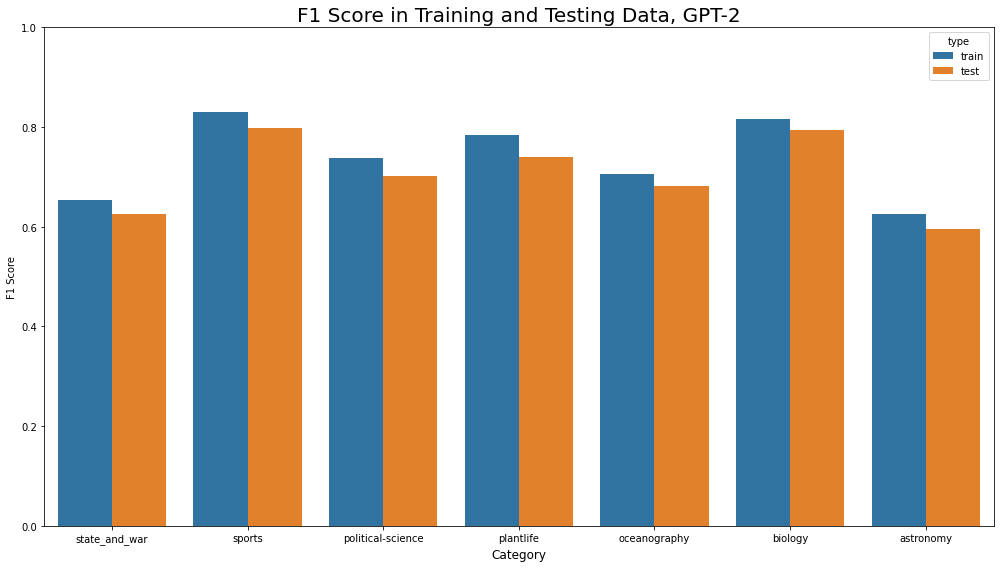

In [ ]:
# see f1 scores
# threshold is just median/mean rounded up to the nearest 0.15
f1_metric = tfa.metrics.F1Score(num_classes = 7, threshold = 0.15)
f1_metric.update_state(y_train, predict_train_data)
train_f1 = f1_metric.result()
f1_metric.update_state(y_test, predict_test_data)
test_f1 = f1_metric.result()

# turn to dataframe
train_f1 = pd.Series(train_f1.numpy()).reset_index().rename(columns = {'index': 'category', 0: 'f1'})
train_f1['type'] = 'train'
test_f1  = pd.Series(test_f1.numpy()).reset_index().rename(columns  = {'index': 'category', 0: 'f1'})
test_f1['type']  = 'test'

gpt2_f1 = pd.concat([train_f1, test_f1]).reset_index(drop = True)\
            .replace({'category': {t: idx for idx, t in zip(sorted(df['topic'].unique()), range(7))}})\
            .sort_values(by = ['category', 'type'], ascending = False)

# plotting
plt.figure(figsize = (14,8))
# can't get it to sort alphabetically for some reason
ax = sns.barplot(x = 'category', y = 'f1', hue = 'type', 
                 data = gpt2_f1, order = list(set(gpt2_f1.category)));
# labels, title and ticks
ax.set_xlabel('Category', fontsize = 12);
ax.set_ylabel('F1 Score'); 
ax.set_title('F1 Score in Training and Testing Data, GPT-2', fontsize = 20); 
ax.xaxis.set_ticklabels(labels); 
ax.set_ylim([0, 1]);
plt.tight_layout()
plt.show()

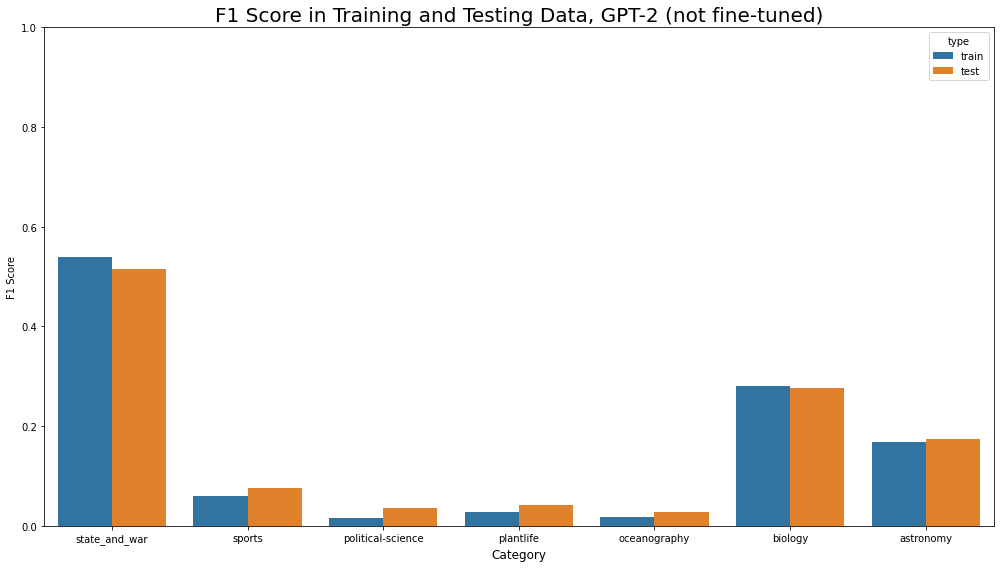

In [57]:
# see f1 scores
# threshold is just median/mean rounded up to the nearest 0.15
f1_metric_untr = tfa.metrics.F1Score(num_classes = 7, threshold = 0.15)
f1_metric_untr.update_state(y_train, untr_pred_train)
untr_train_f1 = f1_metric_untr.result()
f1_metric_untr.update_state(y_test,  untr_pred_test)
untr_test_f1 = f1_metric_untr.result()

# turn to dataframe
untr_train_f1 = pd.Series(untr_train_f1.numpy()).reset_index()\
                  .rename(columns = {'index': 'category', 0: 'f1'})
untr_train_f1['type'] = 'train'
untr_test_f1  = pd.Series(untr_test_f1.numpy()).reset_index()\
                  .rename(columns  = {'index': 'category', 0: 'f1'})
untr_test_f1['type']  = 'test'

untr_gpt2_f1 = pd.concat([untr_train_f1, untr_test_f1]).reset_index(drop = True)\
                 .replace({'category': {t: idx for idx, t in zip(sorted(df['topic'].unique()), range(7))}})\
                 .sort_values(by = ['category', 'type'], ascending = False)

# plotting
plt.figure(figsize = (14,8))
# can't get it to sort alphabetically for some reason
ax = sns.barplot(x = 'category', y = 'f1', hue = 'type', 
                 data = untr_gpt2_f1, order = list(set(untr_gpt2_f1.category)));
# labels, title and ticks
ax.set_xlabel('Category', fontsize = 12);
ax.set_ylabel('F1 Score'); 
ax.set_title('F1 Score in Training and Testing Data, GPT-2 (not fine-tuned)', fontsize = 20); 
ax.xaxis.set_ticklabels(labels); 
ax.set_ylim([0, 1]);
plt.tight_layout()
plt.show()

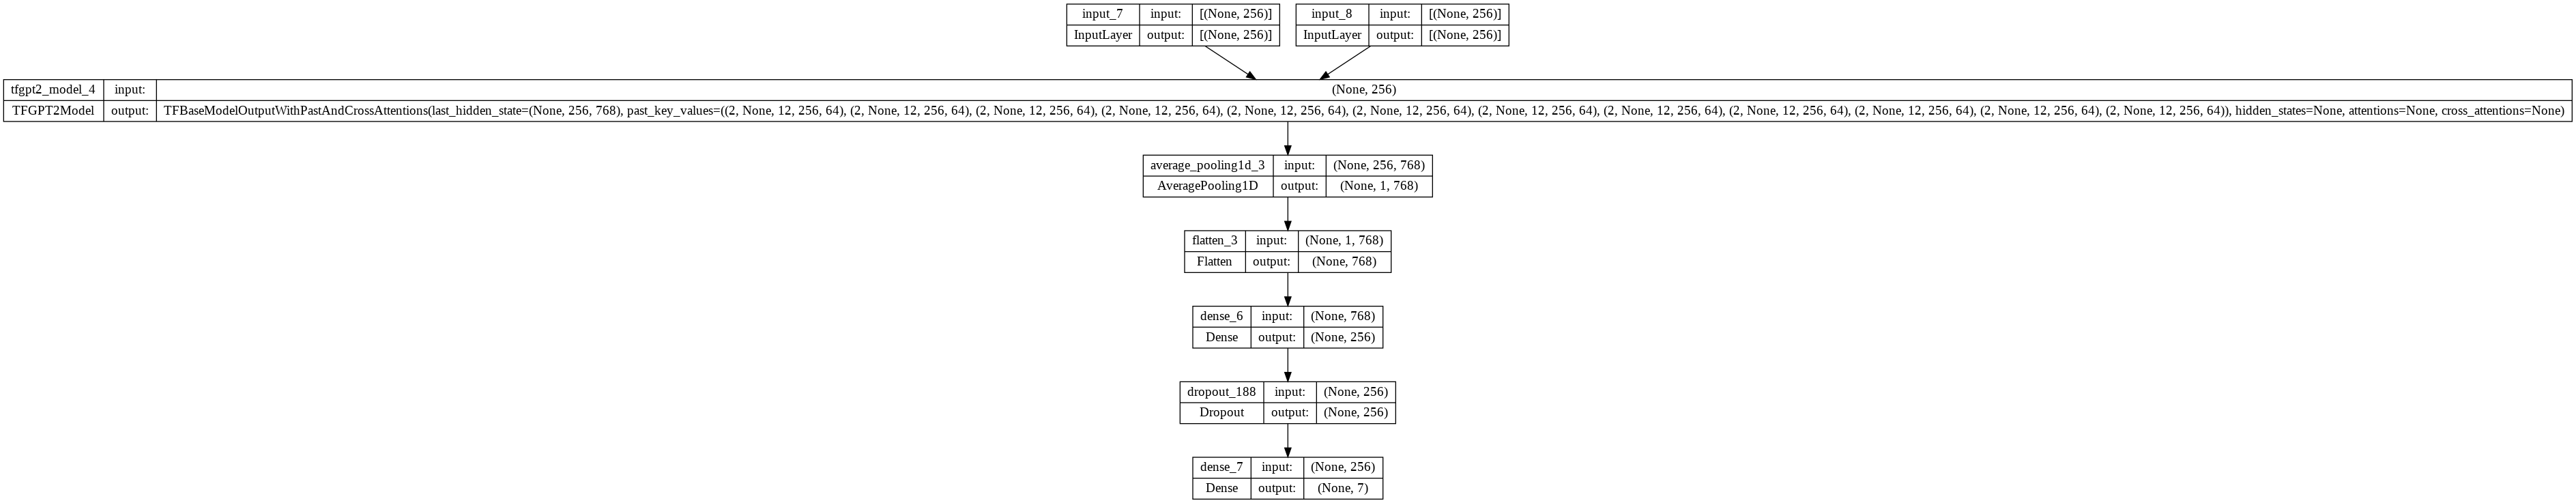

In [62]:
## visualizing model architecture
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_gpt2_plot1.png', show_shapes=True, show_layer_names=True)

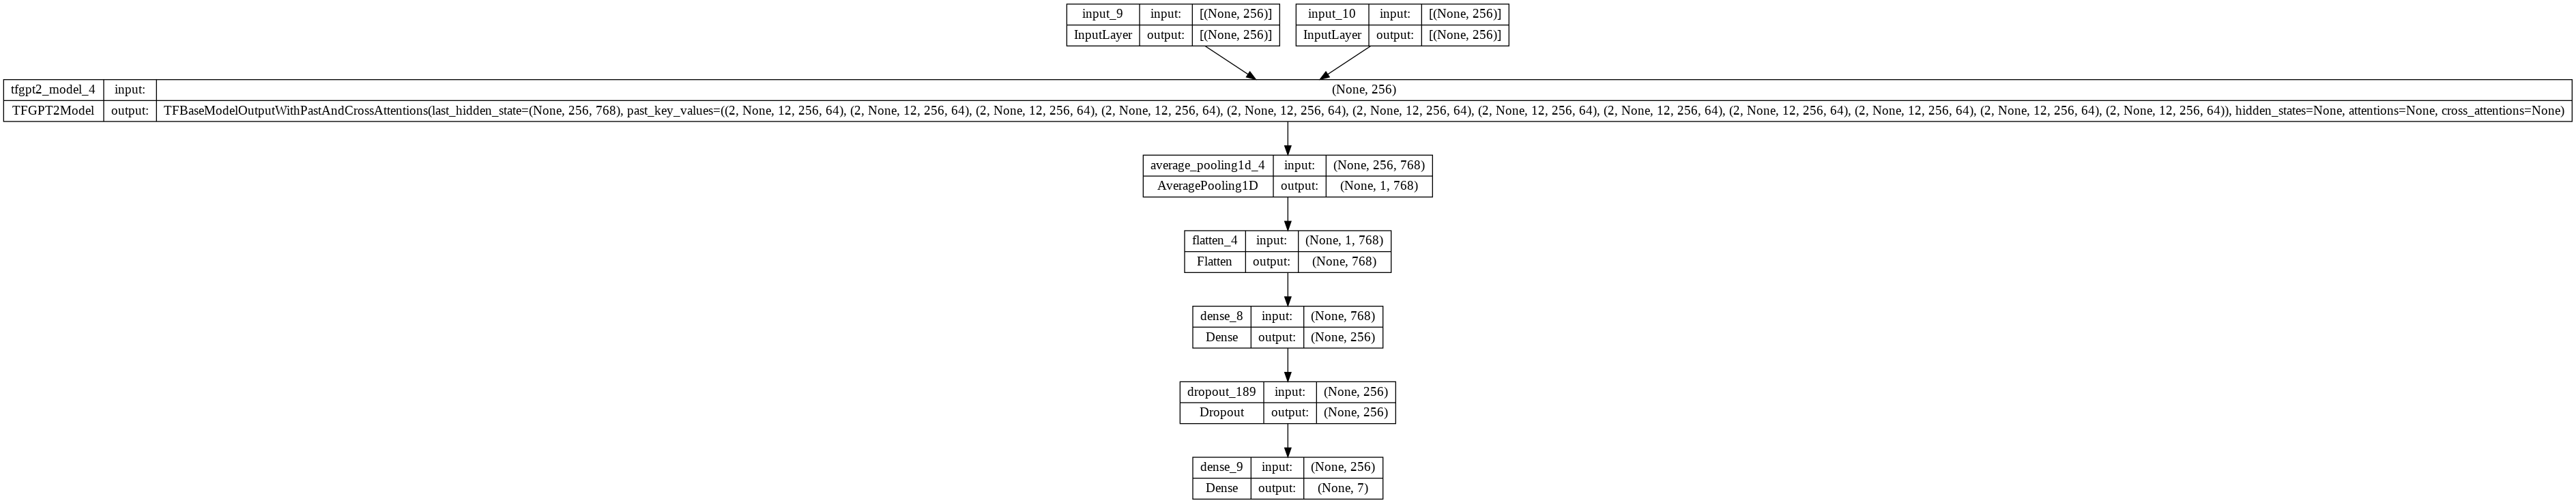

In [63]:
plot_model(model_untr, to_file='model_untr_gpt2_plot1.png', show_shapes=True, show_layer_names=True)